In [2]:
import kipoi
import kipoi_interpret
import numpy as np
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt

/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
Using TensorFlow backend.
/Users/brandon/miniconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/importlib/_bootstrap.py:21

<h1>list all available methods/models


In [4]:
#kipoi.list_models()
kipoi_interpret.importance_scores.available_methods()

{'mutation': kipoi_interpret.importance_scores.ism.Mutation,
 'saliency': kipoi_interpret.importance_scores.gradient.Saliency,
 'grad*input': kipoi_interpret.importance_scores.gradient.GradientXInput,
 'grad': kipoi_interpret.importance_scores.gradient.Gradient,
 'deeplift': kipoi_interpret.importance_scores.referencebased.DeepLift,
 'intgrad': kipoi_interpret.importance_scores.referencebased.IntegratedGradients}

<h1>Kipoi interpret models

In [5]:
# Import Kipoi interpret models

# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
# In-silico mutagenesis-based methods
from kipoi_interpret.importance_scores.ism import Mutation
# DeepLift
from kipoi_interpret.importance_scores.referencebased import DeepLift

In [111]:
# Custom saliency models

class Saliency(Gradient):
    def score(self, input_batch):
        return np.abs(super(Saliency, self).score(input_batch))
    
# Expected data shape for deepbind

seq = "ATGGGCCAGCACACAGACCAGCACGTTGCCCAGGAGCTGTGGGAGGAAGATAAGAGGTATGAACATGATTAGCAAAAGGGCCTAGCTTGGACTCAGAATAA"
seqa = encodeDNA([seq]) # one-hot-encode thesequence
print(seqa.shape)

(1, 101, 4)


<h1>Select Model</h1>

In [31]:
# model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1")
model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF")
# model = kipoi.get_model("DeepBind/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1")
# model = kipoi.get_model("Basenji")
# model = kipoi.get_model("Basset")
# model = kipoi.get_model("pwm_HOCOMOCO/human/AHR")
# model = kipoi.get_model("FactorNet/MAX/onePeak_Unique35_DGF")

Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/arch/0d6747991a525b94a1ac9174459c2bf4
Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/weights/838eb7287139a2542f21984e692a9be2


<h1>Example</h1>

100%|██████████| 1/1 [00:00<00:00, 85.92it/s]


dict_keys(['inputs', 'targets', 'metadata'])
Data shape (10, 101, 4)
Score shape (101, 4)


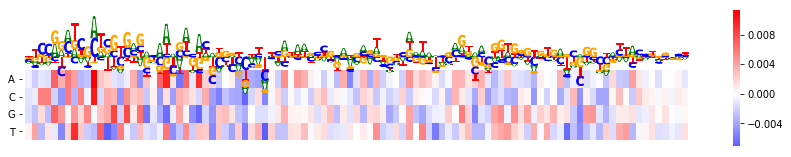

In [110]:
# get the example dataloader
dl_kwargs = model.default_dataloader.download_example('example')
dl = model.default_dataloader(**dl_kwargs)

# load all of the data
all = dl.load_all()  # load the whole dataset
print(all.keys())
data = all['inputs']
print('Data shape', data.shape)

# compute the gradients
gradient = Gradient(model)
val = gradient.score(data)[0]
val /= len(data)
print('Score shape', val.shape)
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h1>Saliency Analysis</h1>

In [33]:
# Gather seq data
path = 'nbt3300-code/data/dream5/chipseq'

import glob
import pandas as pd
allFiles = glob.glob(path + '/*100_genomic*.seq')
# allFiles = glob.glob(path + '/TF_23_CHIP_100*.seq')

list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,header=None, sep='\t')
    list_.append(df)

frame = pd.concat(list_, axis = 0, ignore_index = True)
print('Read data frame', frame.shape)
# frame_ones = frame.loc[frame[1] == 1]
# print(frame_ones.shape)

# Encode the sequences
seqs = frame[0]
print('Sequences shape', seqs.shape)
data = encodeDNA(seqs) # one-hot-encode thesequence
print('Encoded data shape', data.shape)

Read data frame (4992, 2)
Sequences shape (4992,)
Encoded data shape (4992, 101, 4)


<h2>Gradient

Score shape (101, 4)


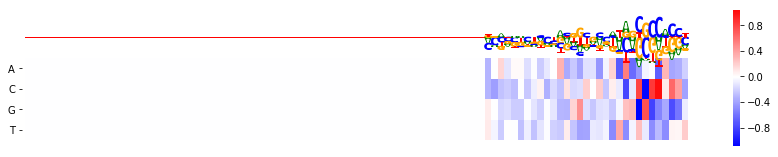

In [27]:
gradient = Gradient(model)
val = gradient.score(data)[0]
print('Score shape', val.shape)
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h2>Gradient*Input

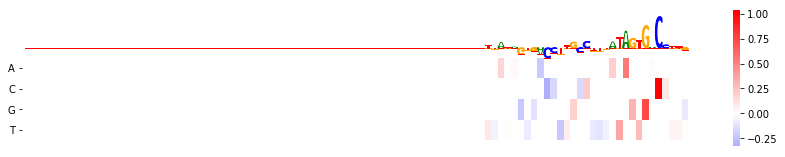

In [28]:
grxinp = GradientXInput(model)
val = grxinp.score(data)[0]
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h2>Absolute Gradient

Score shape (101, 4)


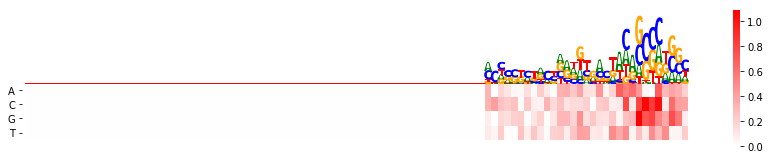

In [35]:
saliency = Saliency(model)
val = saliency.score(data)[0]
print('Score shape', val.shape)
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h2>Model Randomization

In [50]:
print(model.name)
model.get_layers_and_outputs(use_final_layer=True)

DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF


([<keras.layers.merge.Maximum at 0x12a07b6d8>],
 [<tf.Tensor 'maximum_571_2/Maximum:0' shape=(?,) dtype=float32>],
 [2])

In [54]:
km = model.model
print(km.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_819 (InputLayer)          (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_2207 (Lambda)            (None, None, 4)      0           input_819[0][0]                  
__________________________________________________________________________________________________
lambda_2208 (Lambda)            (None, None, 4)      0           lambda_2207[0][0]                
__________________________________________________________________________________________________
conv1d_819 (Conv1D)             (None, None, 16)     2320        lambda_2207[0][0]                
                                                                 lambda_2208[0][0]                
__________

In [108]:
import tensorflow as tf
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

temp_weights = [layer.get_weights() for layer in km.layers]
# print(temp_weights)
print('%s layers' % len(temp_weights))
for l in range(len(temp_weights)):
    layer = temp_weights[i]
    print(layer)
    if len(layer) > 0:
        print(layer)
        for i in range(len(layer)):
            var_shape = temp_weights[layer].shape
            temp_weights[l][i] = np.zeros(var_shape)
#             np.random.random(var_shape)

# print(temp_weights)
            
# for i in range(len(temp_weights)):
#     model.layers[i].set_weights(temp_weights[i])

    

10 layers
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
